In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# product group and starting date

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [7]:
from bktest.backtest_grid_search import *

roll_name = 'expiry'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=datetime.date(2023,3,10),
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
    
print(df.tail(10))


product         AP                                                        \
code            c1                                                         
field        close contract      expiry    high     low      mth    open   
date                                                                       
2023-02-27  9246.0   AP2305  2023-05-17  9274.0  9166.0  24281.0  9207.0   
2023-02-28  9168.0   AP2305  2023-05-17  9262.0  9087.0  24281.0  9246.0   
2023-03-01  9125.0   AP2305  2023-05-17  9146.0  9022.0  24281.0  9112.0   
2023-03-02  9167.0   AP2305  2023-05-17  9195.0  9095.0  24281.0  9125.0   
2023-03-03  9054.0   AP2305  2023-05-17  9190.0  9032.0  24281.0  9133.0   
2023-03-06  9100.0   AP2305  2023-05-17  9184.0  8953.0  24281.0  9030.0   
2023-03-07  9080.0   AP2305  2023-05-17  9178.0  9046.0  24281.0  9105.0   
2023-03-08  9090.0   AP2305  2023-05-17  9119.0  9032.0  24281.0  9070.0   
2023-03-09  8845.0   AP2305  2023-05-17  9150.0  8832.0  24281.0  9092.0   
2023-03-10  

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


# strategy portfolio config

In [12]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 0.0767, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),    
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('custom', 'hc_rb_diff', 0.0767, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
        ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


scenarios_elite2 = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#         ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#         ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#         ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#         ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#         ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [24]:
scen_metrics['expiry_elite'][-1].holdings

product,rb,hc,i,j,jm,FG,v,UR,cu,al,zn,ni,sn,ss
date,,,,,,,,,,,,,,
2014-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-04,26.661144,32.469410,55.166146,46.313312,60.589504,49.073567,18.998393,29.096530,1.484456,6.947328,3.585362,0.523753,0.555690,3.015891
2014-07-07,-24.111650,-29.145654,-50.367740,-40.752754,-50.819415,-42.488497,-17.228875,-25.192133,-1.289741,-6.094316,-3.221155,-0.453472,-0.481124,-2.611195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,29.949807,32.971070,103.794215,29.400285,34.426748,74.714987,20.371338,35.822352,1.982846,7.806022,5.034942,0.283063,0.262278,7.880324
2023-03-07,38.356629,42.788099,128.079307,38.824095,47.915445,98.952768,28.482611,50.111979,2.812922,10.561481,6.962878,0.405213,0.381200,11.281083
2023-03-08,20.076338,23.100906,67.739622,21.428326,26.505483,53.258095,15.053700,26.705604,1.541611,5.748285,3.708235,0.224598,0.215991,6.019937


# run backtest for a portfolio group

In [9]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

In [17]:
holdings.keys()

dict_keys(['CAL_30b_elite', 'CAL_30b_test', 'hot_test', 'hot_elite'])

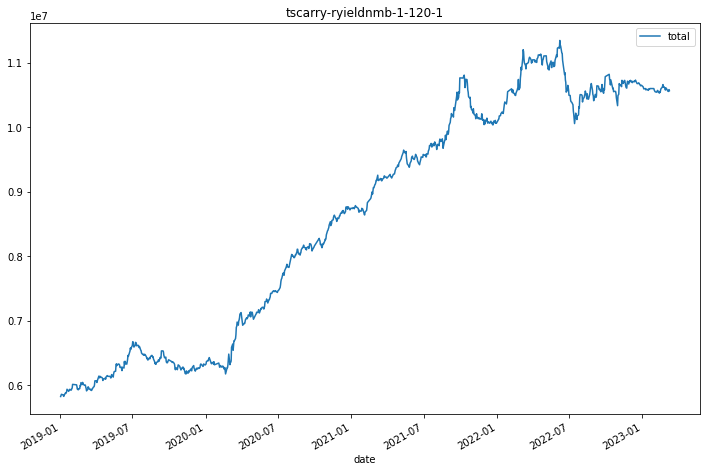

       sharpe       std  sortino
tenor                           
all      1.75  31841.99     2.52
6m      -0.24  41543.33    -0.38
1y      -0.72  53610.86    -1.08
2y       0.85  52343.69     1.32
3y       1.78  47117.37     2.70
4y       1.69  44265.22     2.59
5y       1.64  42340.23     2.51
6y       1.68  39578.20     2.52
7y       1.73  37980.97     2.61
8y       1.68  37149.57     2.54
9y       1.69  35611.33     2.52
10y      1.79  34370.73     2.65
11y      1.81  33235.59     2.67


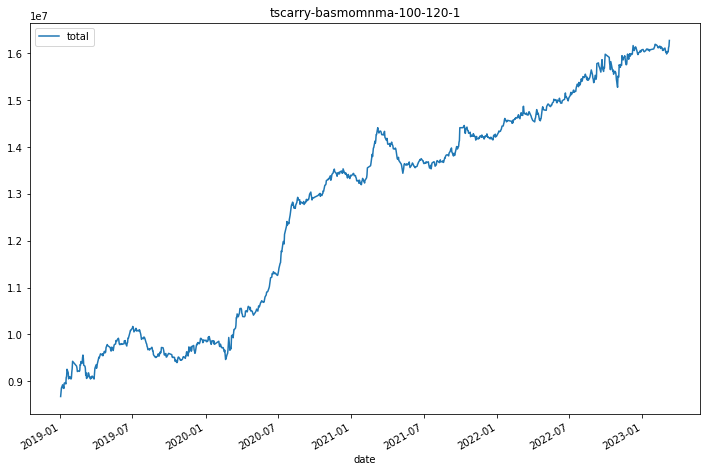

       sharpe       std  sortino
tenor                           
all      1.83  46864.29     2.71
6m       0.89  73835.51     1.42
1y       1.37  65812.25     2.31
2y       1.08  57308.91     1.75
3y       2.38  56448.89     4.10
4y       2.07  55915.86     3.45
5y       1.87  56266.87     3.01
6y       1.89  53624.27     3.02
7y       1.94  52336.18     3.12
8y       1.72  53957.23     2.70
9y       1.76  52268.66     2.76
10y      1.85  50602.62     2.88
11y      1.91  48980.33     2.94


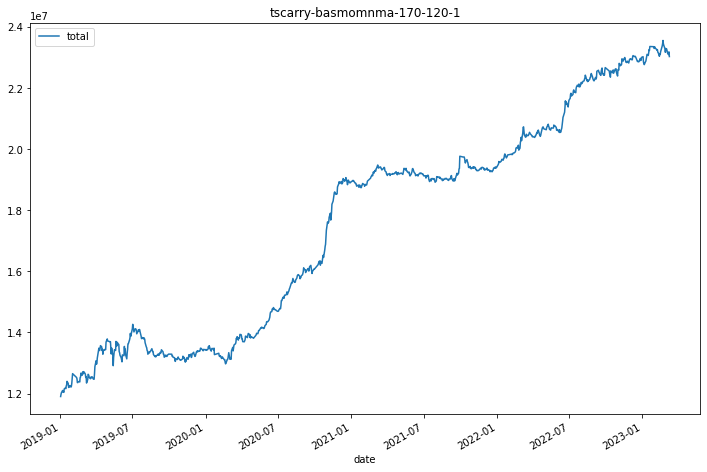

       sharpe       std  sortino
tenor                           
all      1.90  63972.60     2.89
6m       0.79  80572.84     1.34
1y       1.93  76276.87     3.41
2y       1.71  67773.49     3.01
3y       2.94  69294.36     5.22
4y       2.23  76770.78     3.68
5y       2.09  75146.21     3.36
6y       2.00  71731.65     3.19
7y       2.11  72047.10     3.44
8y       1.93  74504.88     3.13
9y       1.95  71608.19     3.14
10y      2.07  69457.19     3.32
11y      2.00  67257.09     3.20


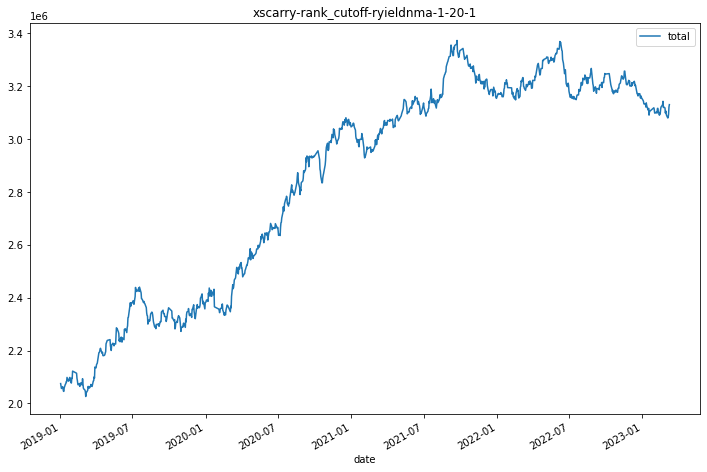

       sharpe       std  sortino
tenor                           
all      1.41  11773.54     2.18
6m      -0.73  10930.54    -1.08
1y      -0.36  12431.81    -0.49
2y       0.33  12811.51     0.48
3y       1.07  13609.97     1.65
4y       1.25  14013.66     1.95
5y       1.21  13649.69     1.91
6y       1.35  13326.27     2.13
7y       1.26  13390.44     2.02
8y       1.33  13292.23     2.12
9y       1.33  12949.35     2.11
10y      1.46  12613.53     2.31
11y      1.51  12212.30     2.35


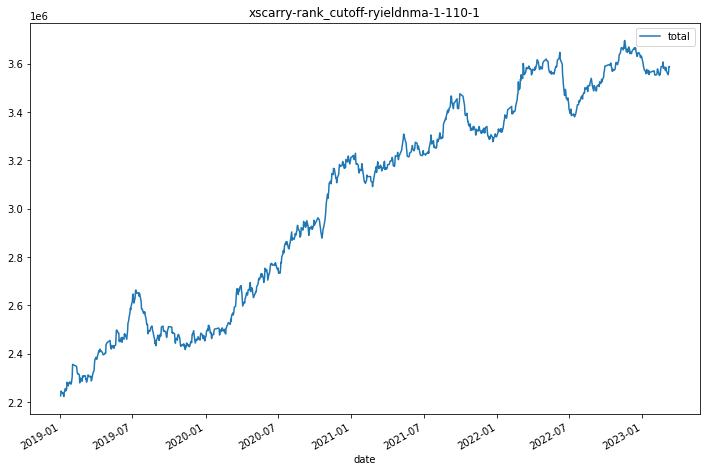

       sharpe       std  sortino
tenor                           
all      1.67  11758.90     2.57
6m       0.94  11360.94     1.34
1y      -0.03  12406.40    -0.04
2y       0.99  13466.04     1.45
3y       1.53  14254.52     2.37
4y       1.49  14040.32     2.35
5y       1.52  13832.15     2.41
6y       1.70  13388.85     2.67
7y       1.62  13268.65     2.57
8y       1.60  13056.42     2.56
9y       1.58  12699.06     2.53
10y      1.69  12466.78     2.65
11y      1.71  12065.18     2.65


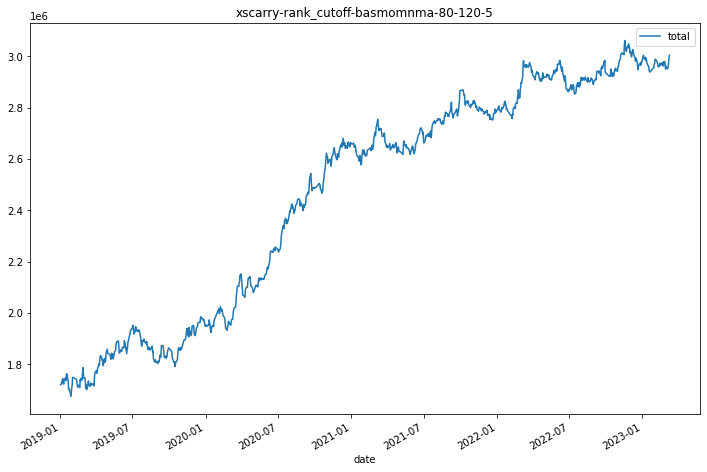

       sharpe       std  sortino
tenor                           
all      1.59  10722.05     2.43
6m       0.64  12849.01     0.95
1y       0.11  11985.38     0.18
2y       0.70  12361.86     1.10
3y       1.72  12824.72     2.79
4y       1.63  12816.01     2.64
5y       1.39  12978.78     2.20
6y       1.38  12389.26     2.17
7y       1.35  12202.51     2.15
8y       1.40  11926.07     2.20
9y       1.43  11503.28     2.24
10y      1.52  11139.31     2.36
11y      1.59  10841.34     2.45


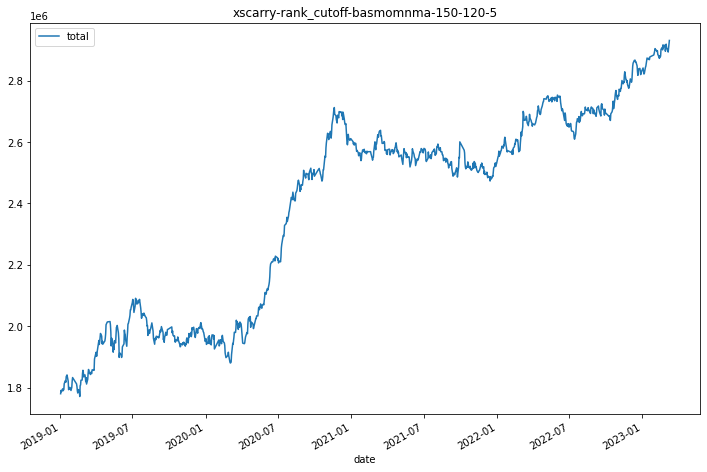

       sharpe       std  sortino
tenor                           
all      1.58  10761.09     2.47
6m       2.51  11576.93     5.02
1y       1.35  11161.83     2.51
2y       0.86  11820.93     1.54
3y       1.69  12511.34     2.87
4y       1.36  13201.76     2.20
5y       1.28  12916.84     2.03
6y       1.37  12346.06     2.16
7y       1.33  12316.48     2.14
8y       1.34  11902.72     2.16
9y       1.40  11461.68     2.21
10y      1.53  11082.14     2.41
11y      1.59  10792.55     2.48


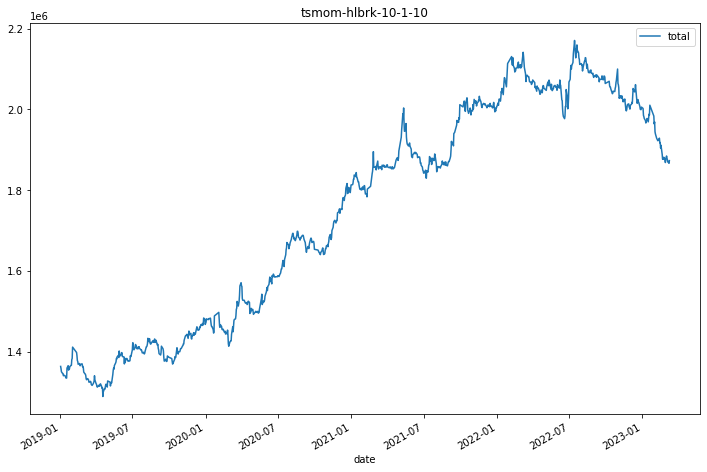

       sharpe       std  sortino
tenor                           
all      1.22   8079.06     1.79
6m      -2.74  10235.41    -3.28
1y      -1.46  11327.18    -1.98
2y       0.05  10927.28     0.07
3y       0.85  10344.96     1.19
4y       0.90   9715.99     1.28
5y       0.96   9293.42     1.40
6y       0.83   8994.94     1.21
7y       0.92   8962.45     1.37
8y       1.00   9080.90     1.46
9y       1.03   8781.06     1.51
10y      1.13   8536.30     1.65
11y      1.25   8304.17     1.82


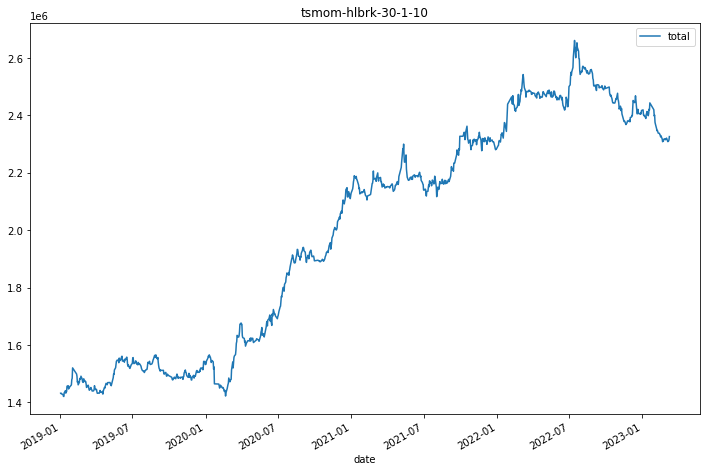

       sharpe       std  sortino
tenor                           
all      1.22  10071.58     1.77
6m      -2.27  10550.54    -2.90
1y      -1.04  12490.94    -1.45
2y       0.35  13475.39     0.53
3y       1.30  12906.91     1.96
4y       1.17  12000.61     1.70
5y       1.16  11439.80     1.71
6y       1.03  11142.63     1.54
7y       0.99  11147.60     1.51
8y       1.09  11280.32     1.63
9y       1.09  10879.98     1.61
10y      1.20  10636.97     1.78
11y      1.30  10350.57     1.91


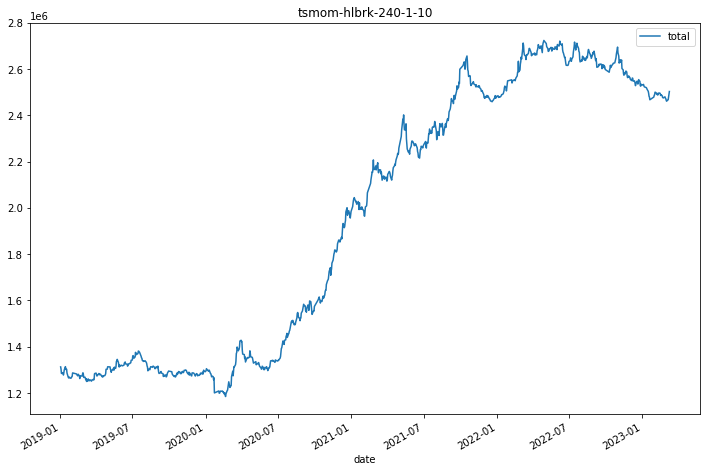

       sharpe       std  sortino
tenor                           
all      1.30  10167.30     1.79
6m      -1.44   9593.25    -2.05
1y      -1.15  11024.71    -1.68
2y       0.79  13870.03     1.19
3y       1.85  13954.57     2.83
4y       1.57  12840.20     2.29
5y       1.36  11899.38     1.97
6y       1.23  11287.79     1.79
7y       1.25  11450.82     1.83
8y       1.21  11649.96     1.78
9y       1.31  11272.56     1.90
10y      1.39  10966.82     2.01
11y      1.40  10657.53     2.01


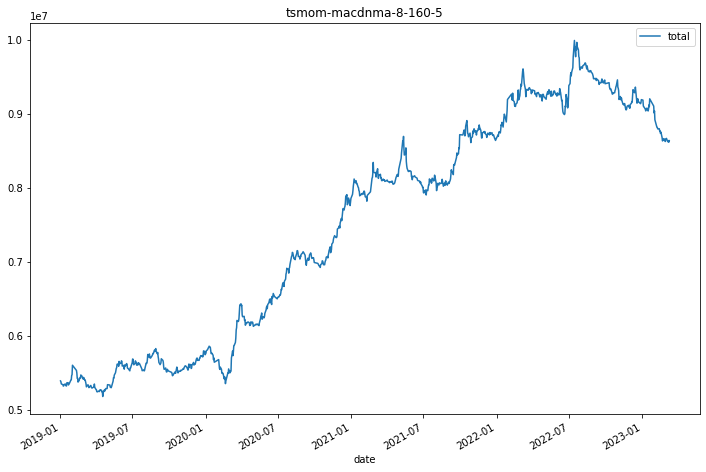

       sharpe       std  sortino
tenor                           
all      1.24  36736.12     1.79
6m      -2.66  41430.49    -3.24
1y      -1.17  50383.64    -1.63
2y       0.30  50686.58     0.44
3y       1.26  48365.05     1.85
4y       1.19  44875.43     1.77
5y       1.06  42750.77     1.58
6y       0.95  41494.75     1.43
7y       0.99  42023.31     1.52
8y       1.08  41924.33     1.63
9y       1.06  40169.11     1.59
10y      1.14  39099.04     1.70
11y      1.25  38066.47     1.85


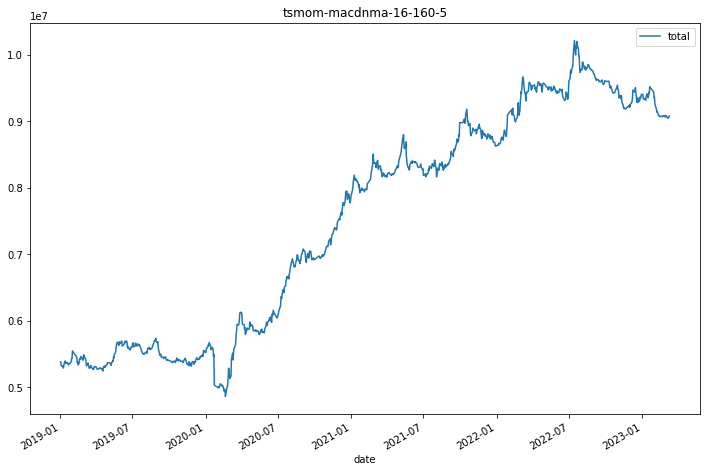

       sharpe       std  sortino
tenor                           
all      1.19  40335.05     1.61
6m      -1.89  38122.00    -2.32
1y      -0.71  49349.01    -0.97
2y       0.47  52781.46     0.68
3y       1.48  51557.14     2.18
4y       1.20  50360.54     1.57
5y       1.02  47604.18     1.37
6y       0.93  46131.85     1.28
7y       0.92  46362.48     1.29
8y       1.05  46117.75     1.47
9y       1.06  44162.00     1.47
10y      1.15  43039.34     1.60
11y      1.20  41804.89     1.66


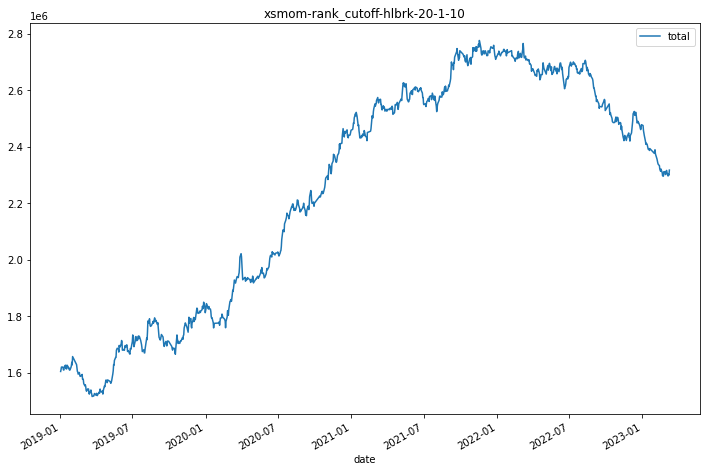

       sharpe       std  sortino
tenor                           
all      1.22  10082.89     1.94
6m      -2.95  11189.24    -4.08
1y      -2.39  11576.94    -3.43
2y      -0.66  12003.77    -1.01
3y       0.75  12128.13     1.18
4y       1.03  12224.05     1.70
5y       0.93  12102.09     1.56
6y       0.86  11747.16     1.46
7y       0.78  11653.08     1.31
8y       0.97  11402.84     1.64
9y       1.02  11091.85     1.68
10y      1.12  10759.29     1.83
11y      1.28  10447.82     2.06


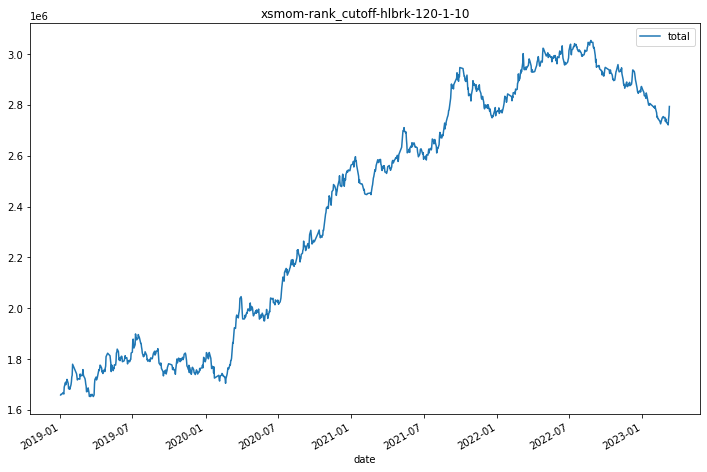

       sharpe       std  sortino
tenor                           
all      1.32  11683.55     2.09
6m      -1.88  11240.34    -3.41
1y      -0.96  12251.40    -1.43
2y       0.50  13779.02     0.82
3y       1.40  14171.60     2.36
4y       1.28  14074.70     2.22
5y       1.14  13972.48     1.95
6y       1.02  13600.33     1.71
7y       0.93  13436.28     1.57
8y       0.99  13055.50     1.67
9y       1.09  12679.45     1.79
10y      1.22  12262.59     1.98
11y      1.35  11927.17     2.17


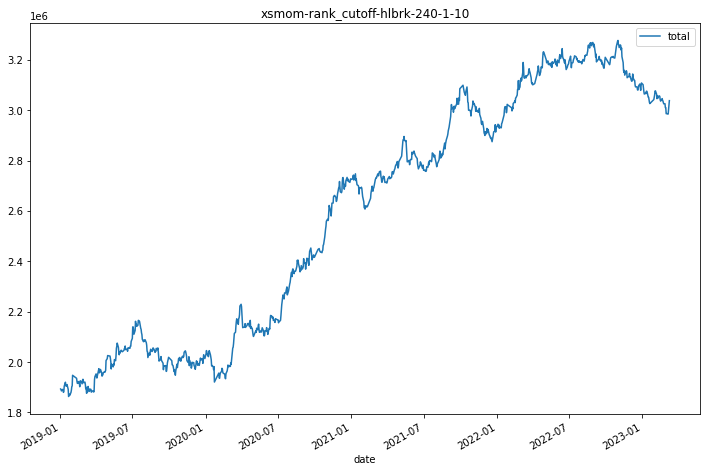

       sharpe       std  sortino
tenor                           
all      1.47  11880.16     2.24
6m      -1.77  11760.82    -2.54
1y      -0.66  12644.48    -0.93
2y       0.68  13835.93     1.06
3y       1.47  14265.59     2.36
4y       1.31  14234.19     2.10
5y       1.29  14077.52     2.07
6y       1.29  13810.25     2.06
7y       1.11  13605.11     1.77
8y       1.13  13240.65     1.79
9y       1.20  12745.46     1.87
10y      1.33  12306.35     2.04
11y      1.48  11959.22     2.25


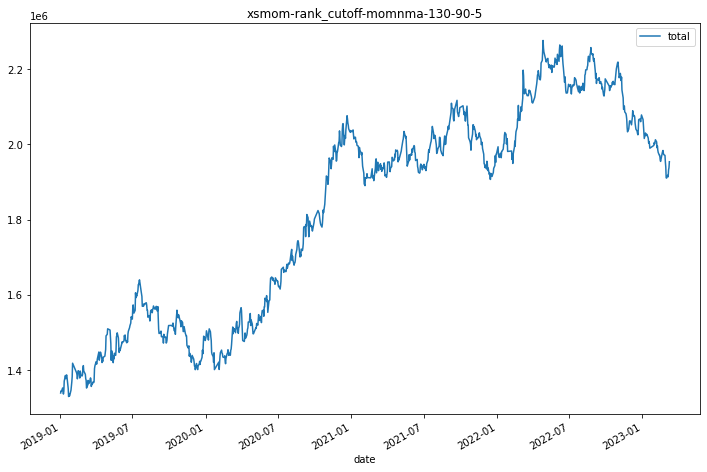

       sharpe       std  sortino
tenor                           
all      0.94  11851.93     1.45
6m      -2.54  11476.12    -4.02
1y      -1.12  13029.02    -1.73
2y       0.04  14116.39     0.07
3y       0.64  14621.37     1.05
4y       0.67  14415.05     1.09
5y       0.66  14069.13     1.08
6y       0.74  13762.61     1.21
7y       0.64  13623.80     1.04
8y       0.80  13301.01     1.29
9y       0.77  12814.93     1.23
10y      0.84  12340.86     1.32
11y      0.95  11975.66     1.48


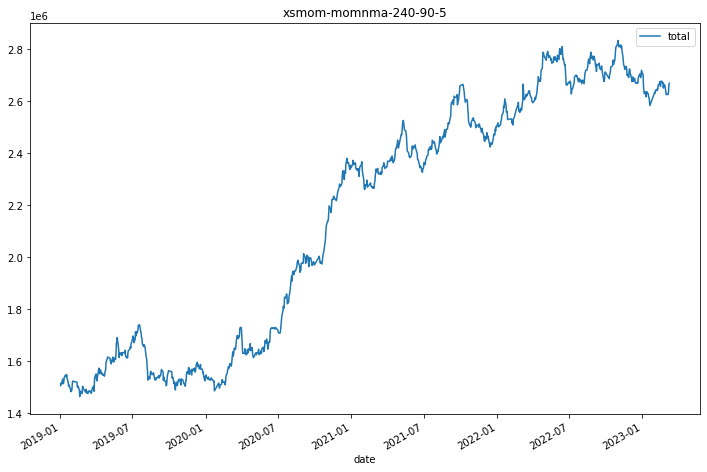

       sharpe       std  sortino
tenor                           
all      1.33  11953.69     2.03
6m      -0.70  13443.46    -1.11
1y       0.16  13994.05     0.27
2y       0.77  14376.09     1.27
3y       1.52  14538.28     2.49
4y       1.33  14376.96     2.16
5y       1.16  14016.14     1.91
6y       1.31  13920.67     2.14
7y       1.17  13584.47     1.88
8y       1.04  13188.71     1.66
9y       1.12  12694.16     1.76
10y      1.25  12255.59     1.94
11y      1.33  11953.69     2.03


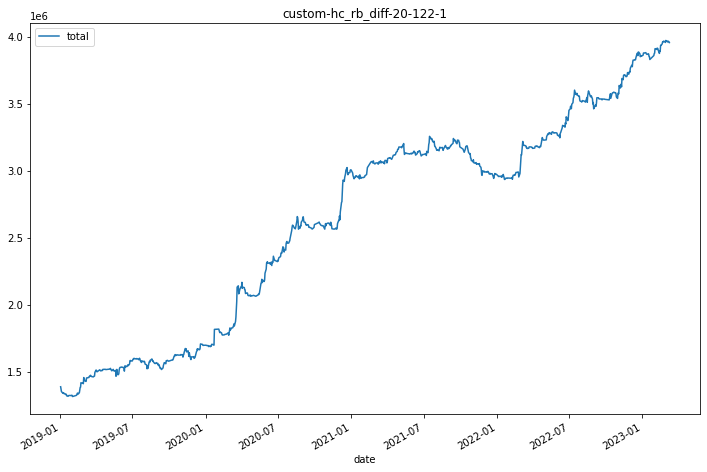

       sharpe       std  sortino
tenor                           
all      1.71  17031.62     2.77
6m       3.48  15654.68     7.05
1y       3.04  16184.95     5.43
2y       1.86  15682.43     3.21
3y       2.61  17463.30     4.59
4y       2.42  16647.84     4.18
5y       2.11  16533.93     3.51
6y       1.67  16868.39     2.67
7y       1.82  16997.79     2.93
8y       1.80  17316.02     2.92
9y       1.71  17031.62     2.77
10y      1.71  17031.62     2.77
11y      1.71  17031.62     2.77


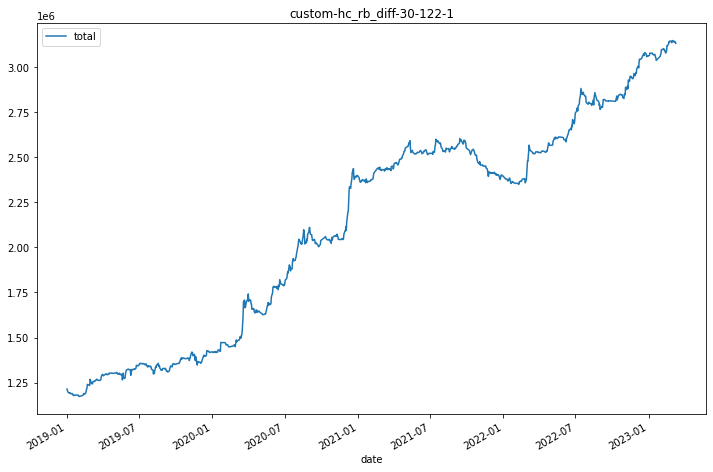

       sharpe       std  sortino
tenor                           
all      1.69  13644.55     2.65
6m       3.69  11178.30     7.82
1y       3.15  12073.48     5.69
2y       1.91  11898.40     3.37
3y       2.57  13676.91     4.48
4y       2.36  12740.68     3.95
5y       2.06  12647.40     3.31
6y       1.59  13309.02     2.45
7y       1.80  13483.56     2.82
8y       1.79  13861.82     2.81
9y       1.69  13644.55     2.65
10y      1.69  13644.55     2.65
11y      1.69  13644.55     2.65


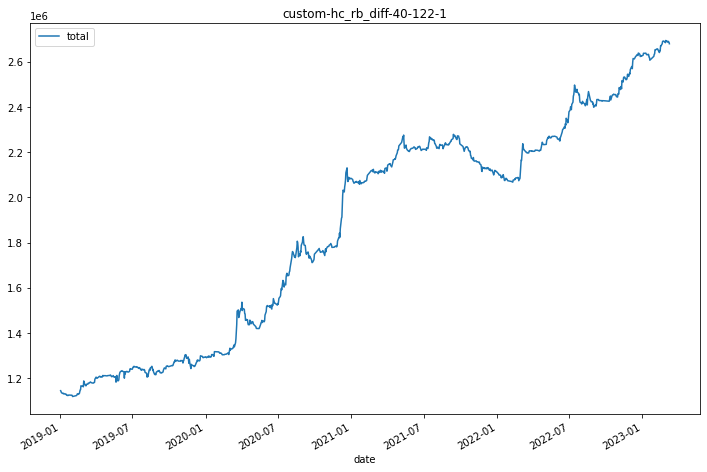

       sharpe       std  sortino
tenor                           
all      1.68  11757.62     2.56
6m       3.83   8529.55     8.19
1y       3.09   9701.59     5.31
2y       1.90   9689.98     3.28
3y       2.50  11523.73     4.19
4y       2.28  10625.07     3.65
5y       1.99  10517.44     3.09
6y       1.52  11316.34     2.27
7y       1.77  11510.26     2.71
8y       1.79  11942.42     2.72
9y       1.68  11757.62     2.56
10y      1.68  11757.62     2.56
11y      1.68  11757.62     2.56


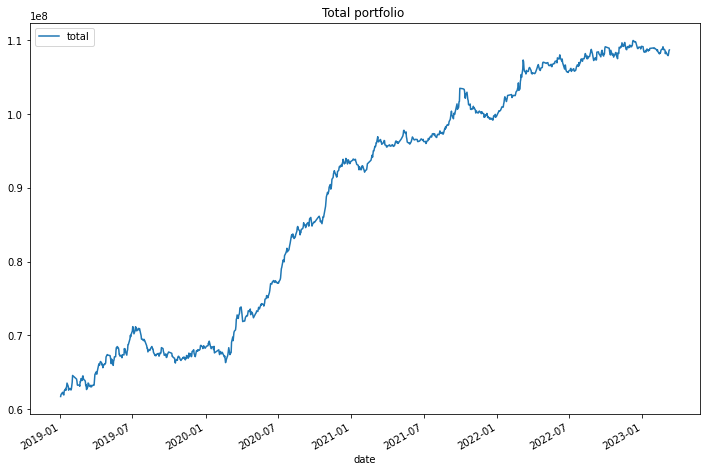

       sharpe        std  sortino
tenor                            
all      2.33  246084.48     3.68
6m       0.14  280815.29     0.22
1y       0.36  281385.16     0.57
2y       1.32  299499.32     2.13
3y       2.65  313538.92     4.52
4y       2.31  319660.52     4.00
5y       2.15  315052.81     3.64
6y       2.18  297995.20     3.62
7y       2.19  293479.04     3.70
8y       2.19  285002.30     3.70
9y       2.23  274583.61     3.72
10y      2.38  266815.35     3.93
11y      2.43  258071.53     3.98
                   total
date                    
2023-01-09  1.085224e+08
2023-01-10  1.083932e+08
2023-01-11  1.086319e+08
2023-01-12  1.086966e+08
2023-01-13  1.089622e+08
2023-01-16  1.084831e+08
2023-01-17  1.086585e+08
2023-01-18  1.086723e+08
2023-01-19  1.086018e+08
2023-01-20  1.085297e+08
2023-01-30  1.088924e+08
2023-01-31  1.087915e+08
2023-02-01  1.088168e+08
2023-02-02  1.088917e+08
2023-02-03  1.089209e+08
2023-02-06  1.087538e+08
2023-02-07  1.085474e+08
2023-02-08  1.0

In [13]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2023,3,10)

scenario_map = {
    'test': scenarios_test,
    'elite': scenarios_elite,
}

shift_mode = 1
rev_char = '!'
exec_mode = 'open'
total_risk = 4600.0*34
asset_scaling = False
cost_ratio = 0.0
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni']

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'elite'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

product_offsets = misc.product_trade_offsets(product_list)
run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['cost_ratio'] = cost_ratio
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='px', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

holdings[run_key] = pos_sum

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg, offsets=product_offsets, cost_ratio=cost_ratio)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))

bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices)
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


In [21]:
port_pnl.to_csv(file_folder + "port_pnl.csv")

In [16]:
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)


In [13]:
ts1 = bt_empirics['hot_elite'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']
ts2 = bt_empirics['hot_test'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']


# holding and std for strategy group

In [13]:
file_folder = "C:\\dev\\data\\data_cache\\"

#port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl_est.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product             rb          hc            i           j           jm  \
date                                                                       
2011-01-05    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-06    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-07    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-10    0.000000    0.000000     0.000000    0.000000     0.000000   
2011-01-11    0.000000    0.000000     0.000000    0.000000     0.000000   
...                ...         ...          ...         ...          ...   
2023-02-24  604.808482  735.324362  2549.031610  724.911486  1243.721959   
2023-02-27  806.274123  848.178152  2688.410716  760.985279  1056.453553   
2023-02-28  643.979541  630.660872  2977.451883  825.346491  1280.977788   
2023-03-01  675.590222  849.247004  3181.068205  760.230648  1016.117231   
2023-03-02  702.130979  828.766438  3425.999538  870.561510  1075.949249   

product    

In [14]:
tenors = ['1y', '2y', '3y']
data_list = []

for scen_name, scen, pl_stat in zip(scen_names, scenarios, scen_stats):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

,weight,std_1y,std_2y,std_3y,sharpe_1y,sharpe_2y,sharpe_3y
strat_name,,,,,,,
tscarry-ryieldnmb-1-120-1,2.00,56879.946702,52438.738036,48757.922892,0.082731,0.953512,1.766979
tscarry-basmomnma-100-120-1,1.00,61264.390270,54643.053510,55879.353252,1.391959,0.692579,1.609770
tscarry-basmomnma-170-120-1,1.00,67149.816666,66060.167156,65832.540449,2.496981,1.671361,2.360332
xscarry-rank_cutoff-ryieldnma-1-20-1,1.90,13486.721009,14206.018134,14911.241365,-0.938875,0.439885,1.289179
xscarry-rank_cutoff-ryieldnma-1-110-1,2.10,15092.368877,15361.461750,15475.756400,0.593777,0.949576,1.312782
xscarry-rank_cutoff-basmomnma-80-120-5,2.50,11744.080065,11439.039383,12066.251308,1.227265,0.805267,1.795526
xscarry-rank_cutoff-basmomnma-150-120-5,2.50,11760.165684,11936.470859,12046.085857,2.360059,1.301532,2.094659
tsmom-hlbrk-10-1-10,1.10,11386.367881,10947.271603,10459.463308,-1.394340,-0.054149,0.873848
tsmom-hlbrk-30-1-10,0.90,12705.855860,13448.991497,13184.789942,-0.920826,0.180686,1.279280


# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.323876  0.809957  0.724711  0.475860  0.428585  0.562446   
sharpe_6m  -0.890350  0.134250  1.753153       NaN       NaN -0.504611   
sharpe_1y  -0.267060  1.519788  0.586632 -1.891429       NaN  0.957608   
sharpe_2y  -0.190253  1.125374  0.300596  0.216499  0.535823  0.590105   
sharpe_3y   0.494870  1.888858  1.184239 -0.237671  0.420748  0.337683   
sharpe_4y   0.449147  1.456568  0.949912  0.112318  0.035228  0.506445   
sharpe_5y   0.199359  1.256697  0.883913  0.001861  0.174178  0.603708   
sharpe_6y   0.094969  1.078674  0.749858  0.471455  0.037831  0.671506   
sharpe_7y   0.088793  0.990913  0.828085  0.557333  0.526836  0.562704   
sharpe_8y   0.314868  0.856111  0.783751  0.652089  0.409960  0.513486   
sharpe_9y   0.331092  0.809957  0.738972  0.578575  0.449763  0.534781   
sharpe_10y  0.311325  0.809957  0.724711  0.650699  0.428585  0.591412   
sharpe_11y  0.323876  0.809957  0.7247

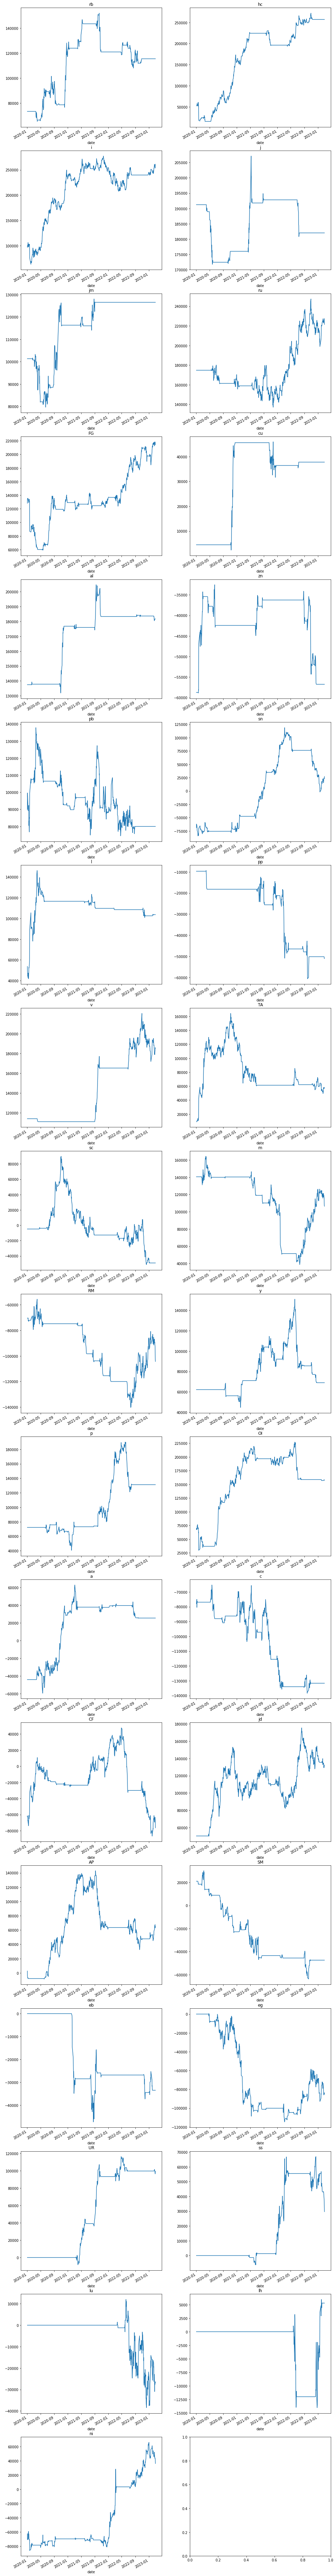

In [15]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2020-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


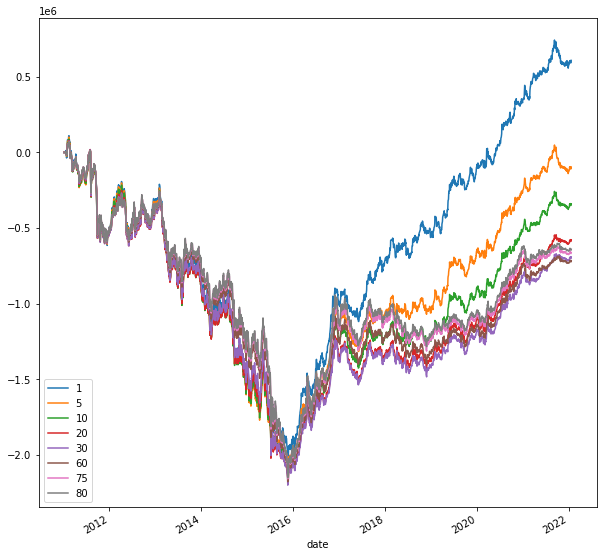

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


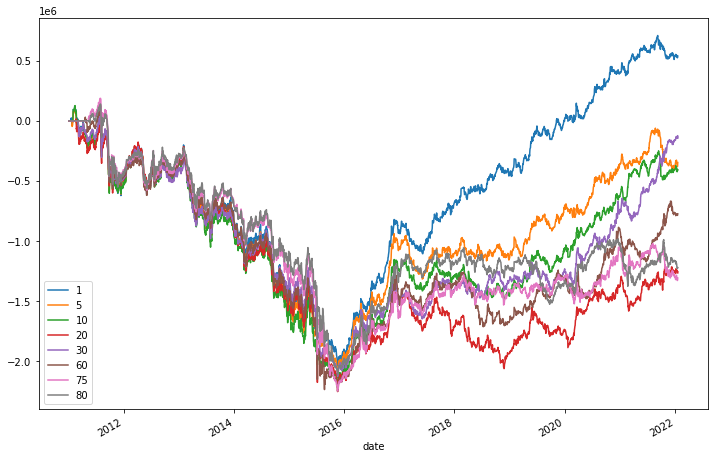

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

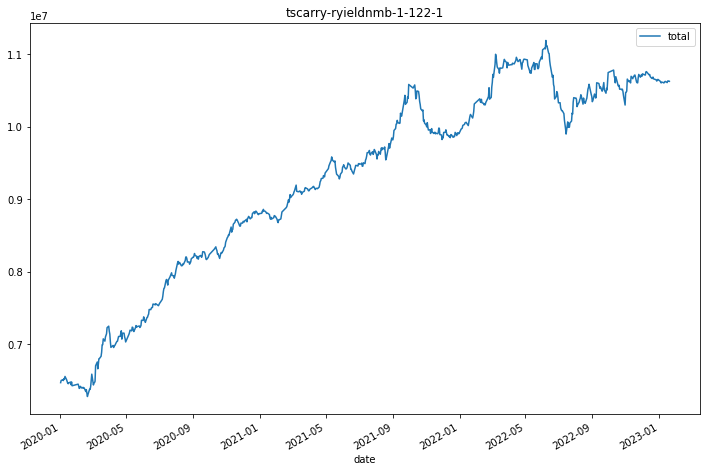

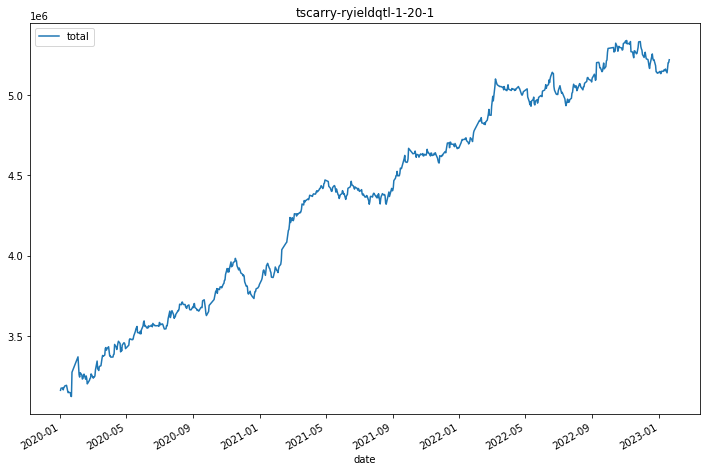

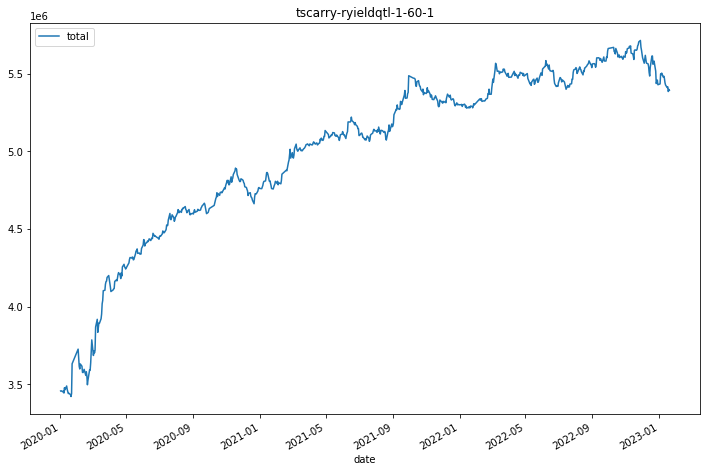

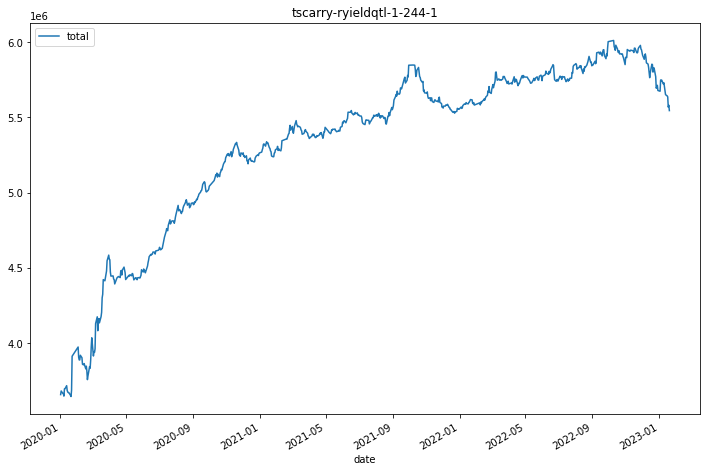

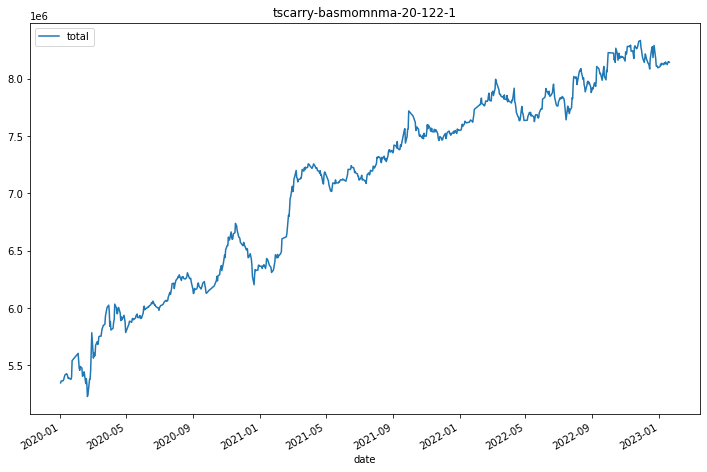

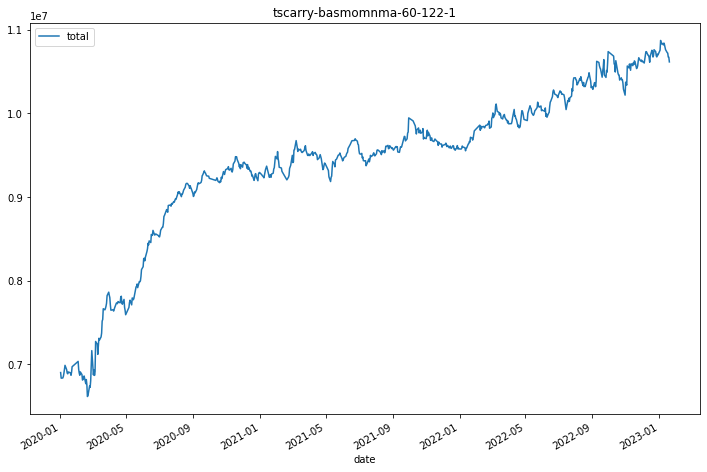

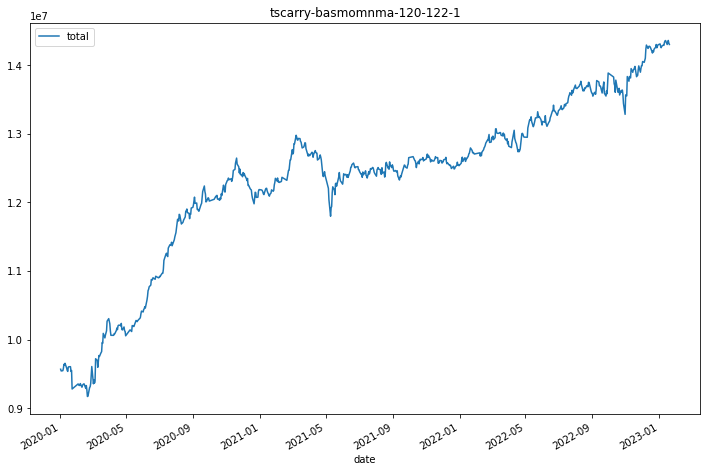

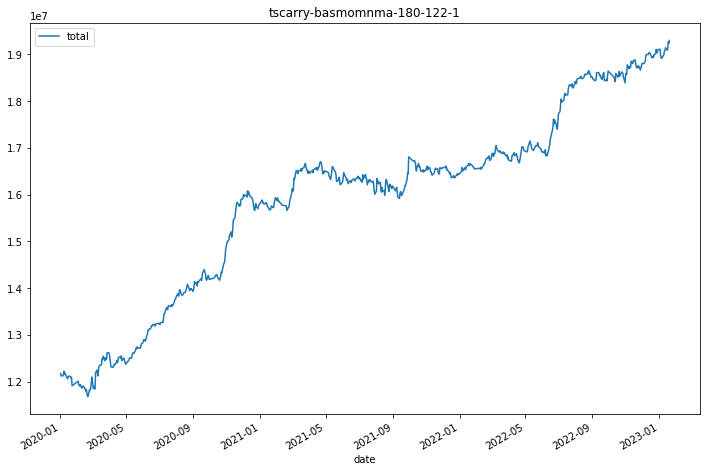

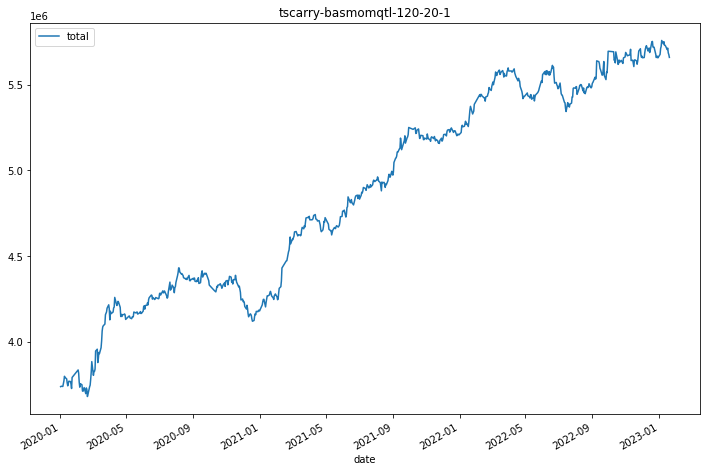

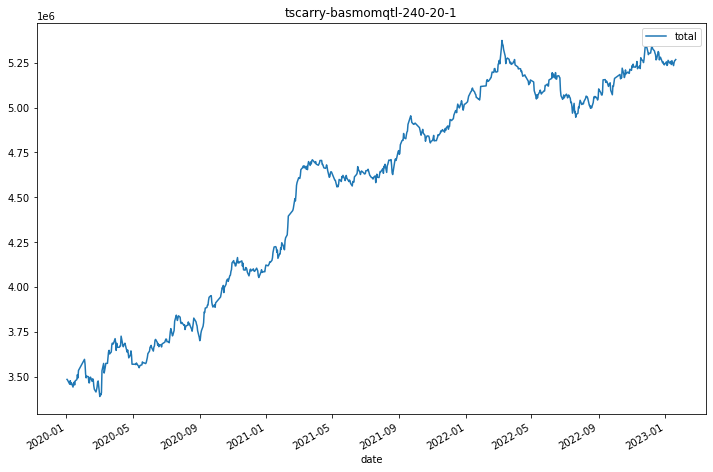

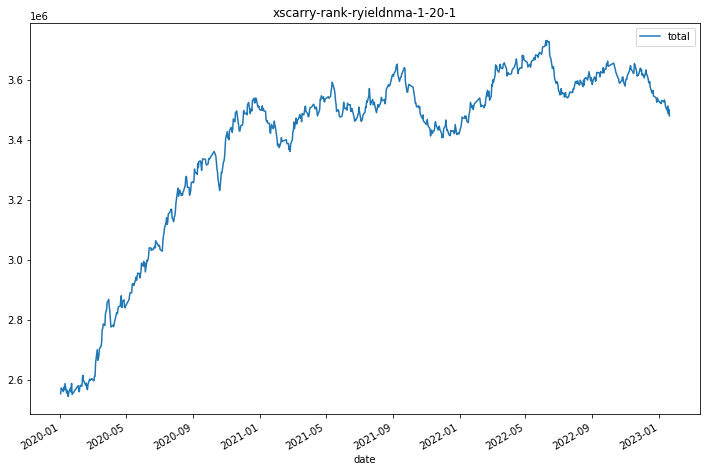

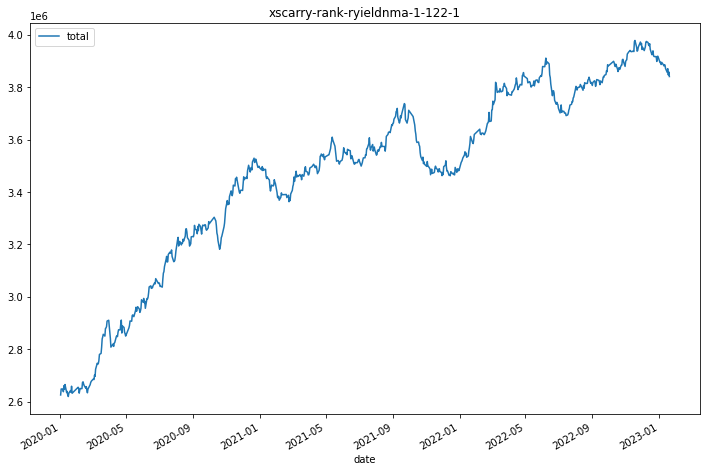

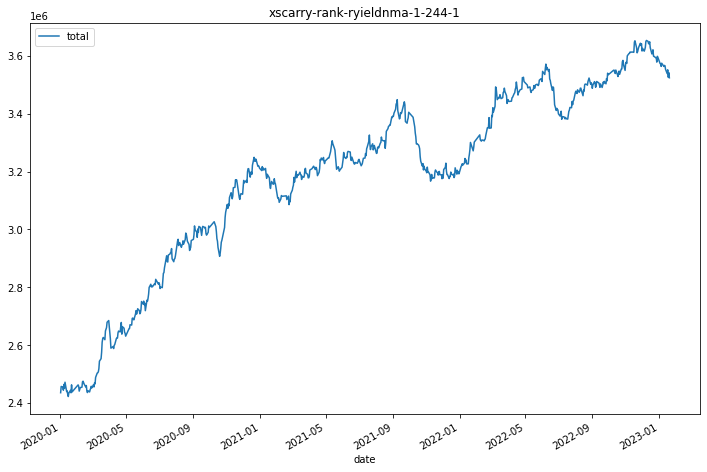

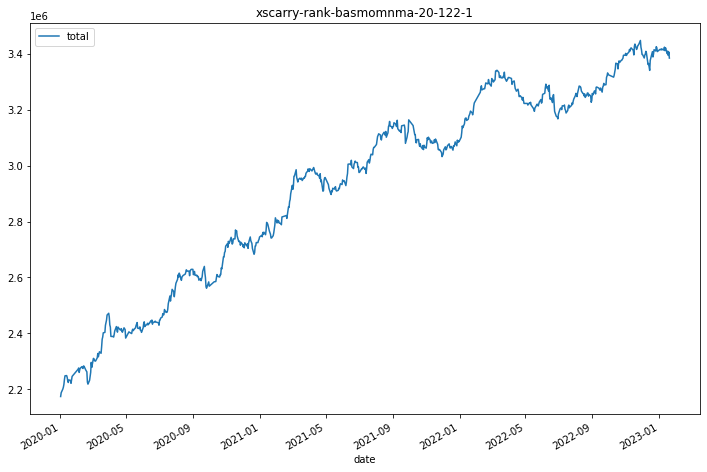

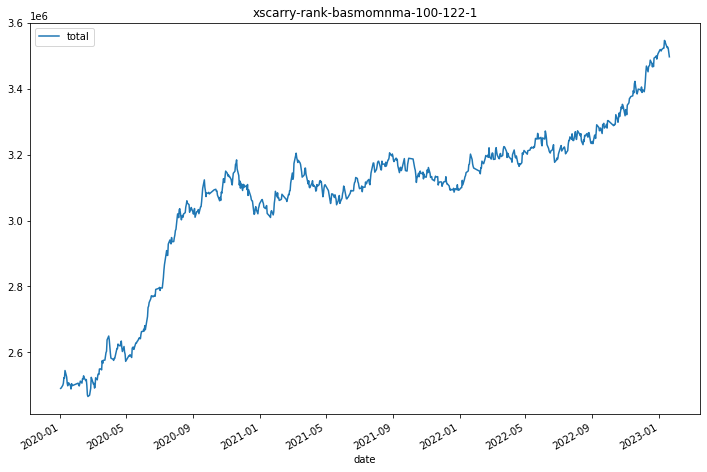

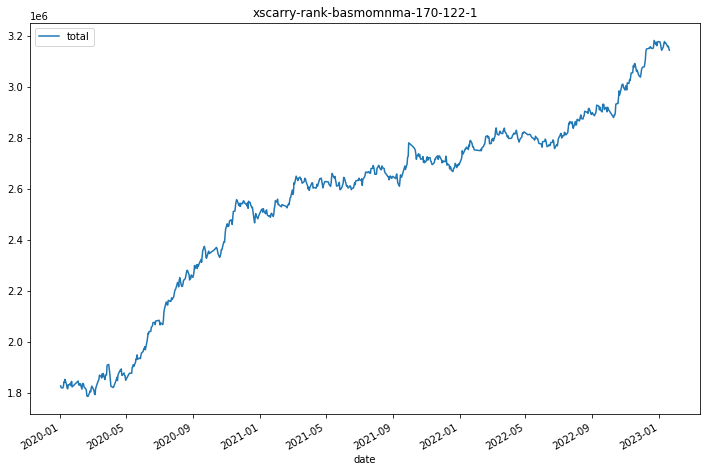

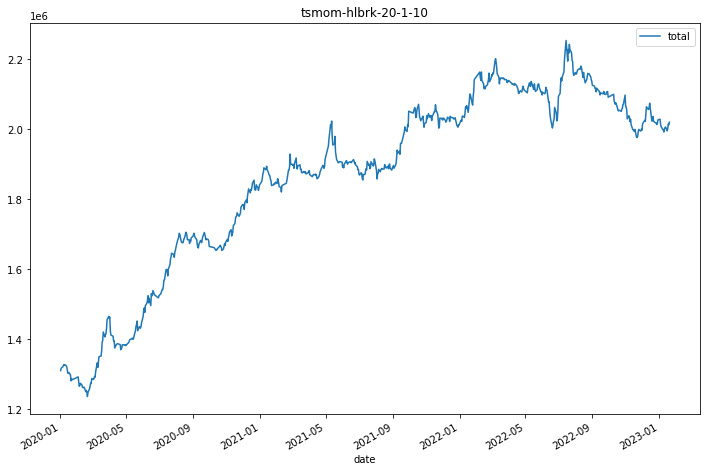

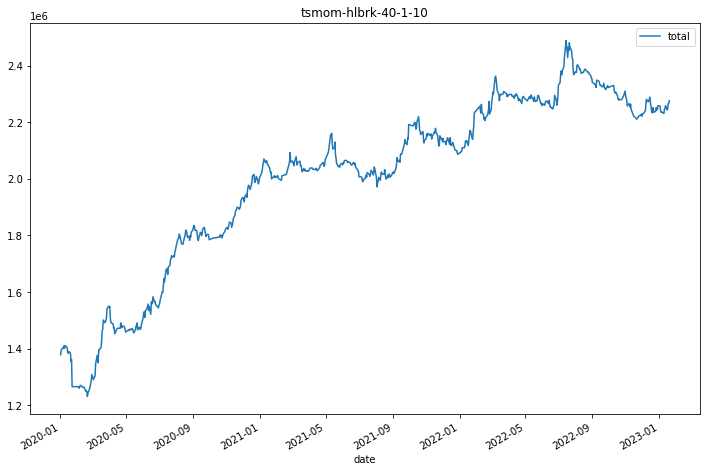

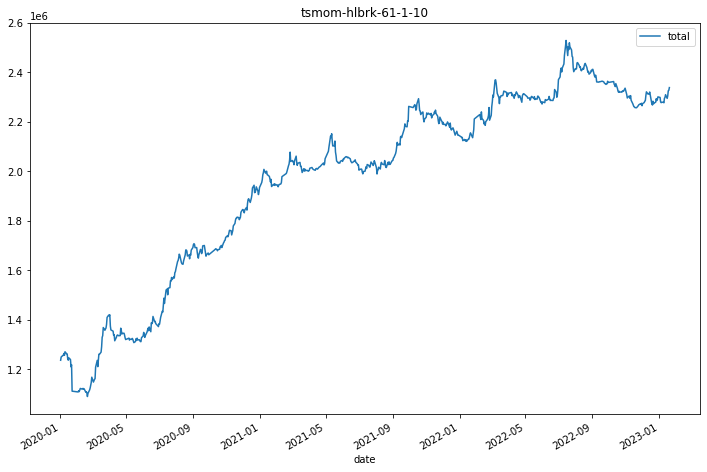

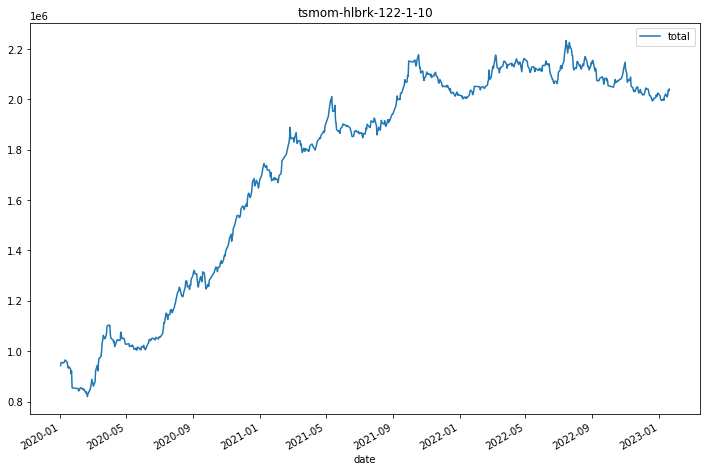

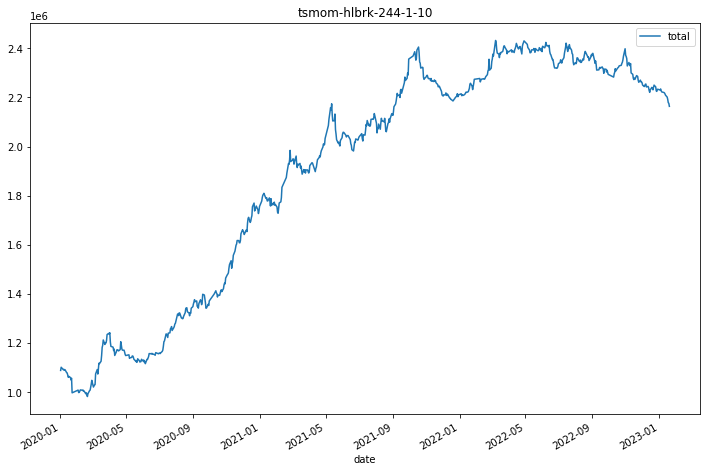

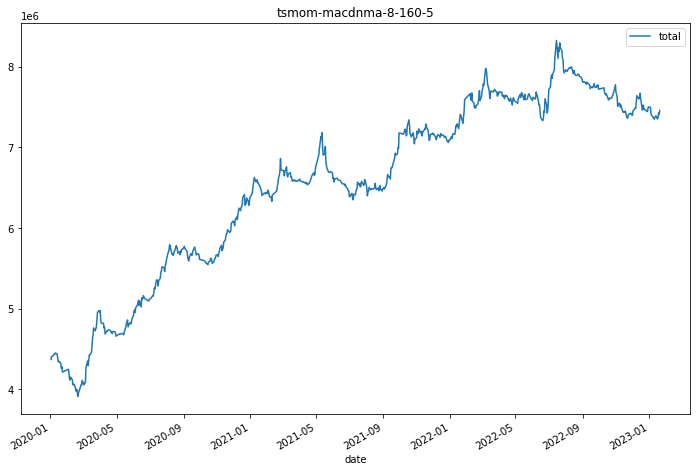

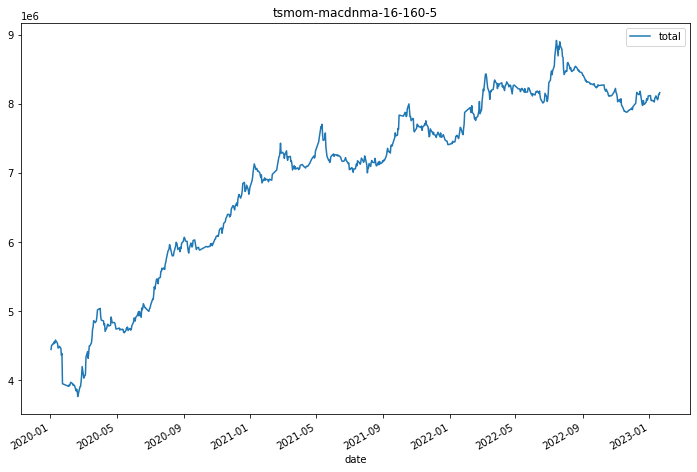

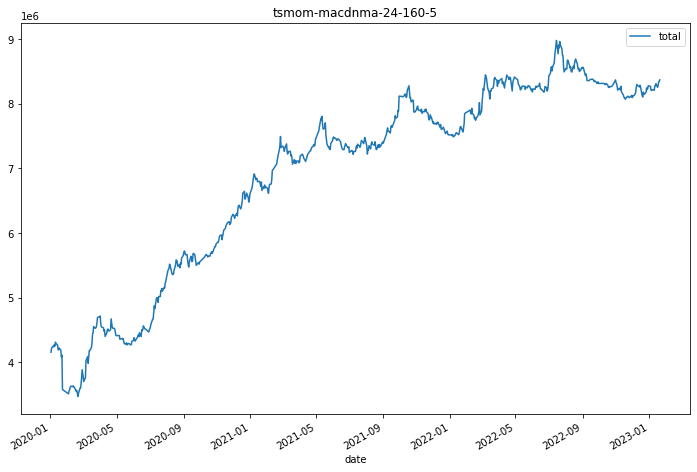

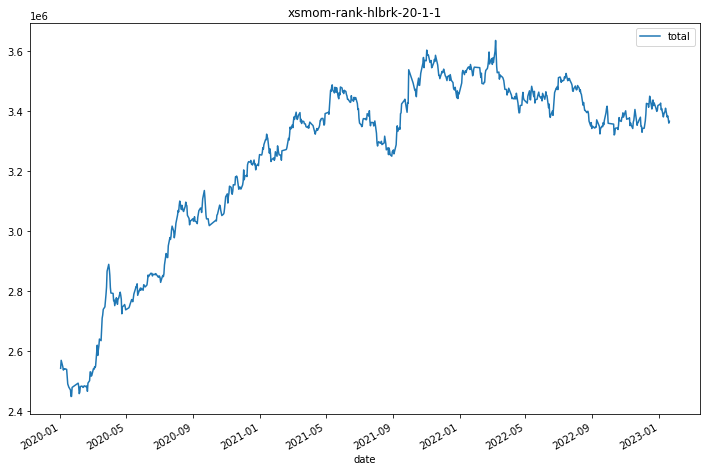

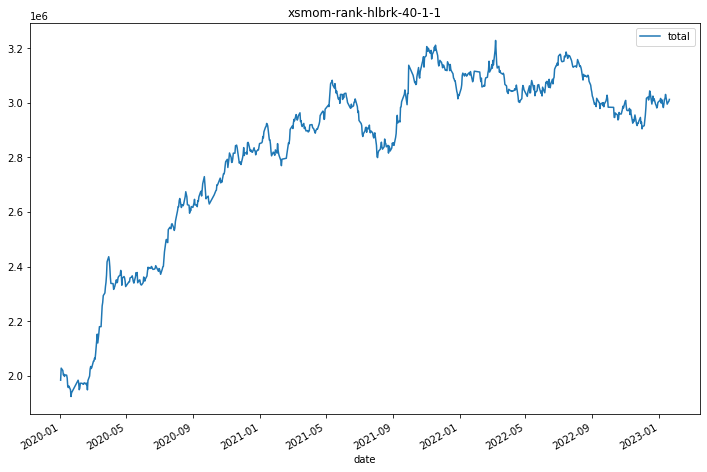

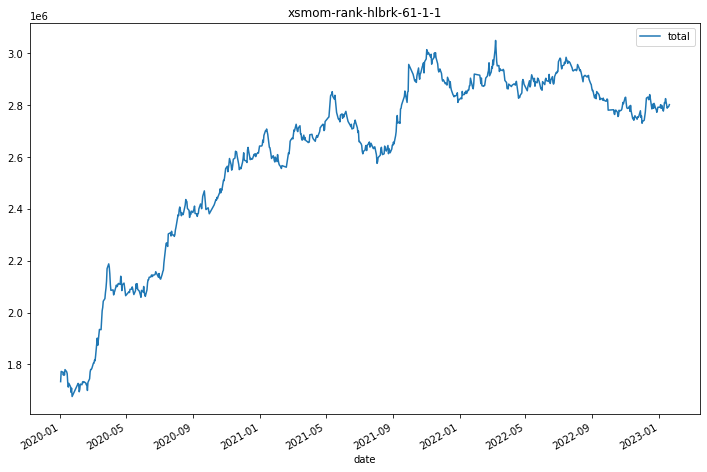

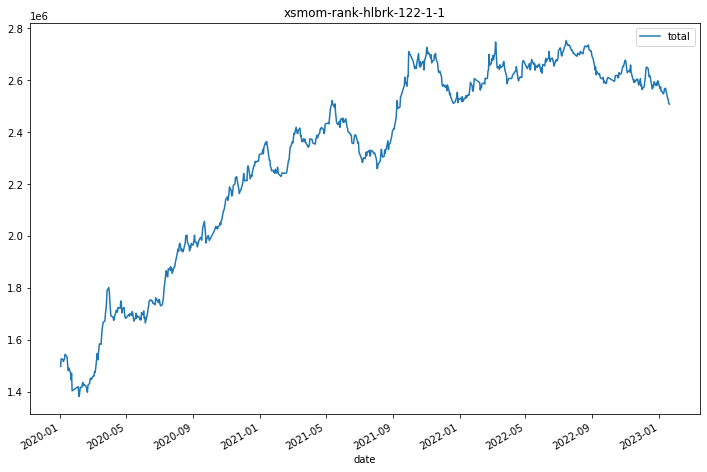

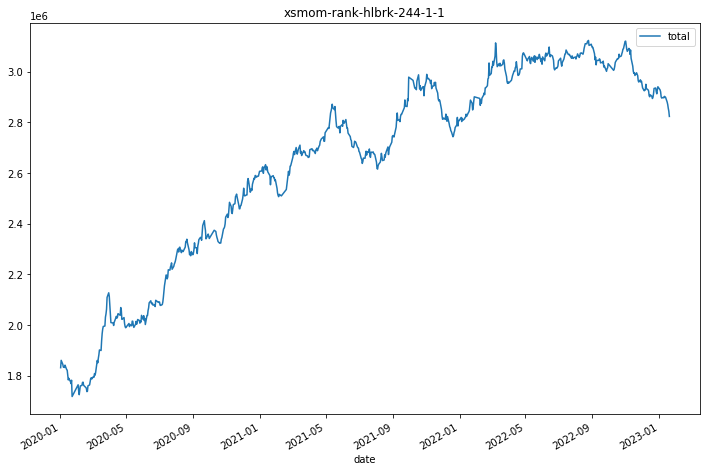

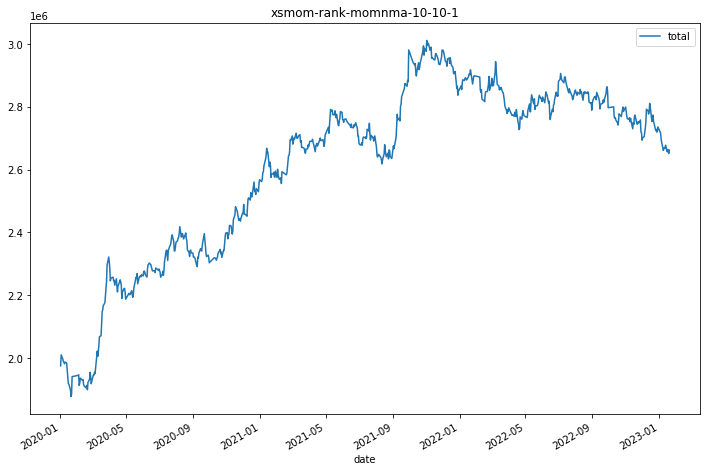

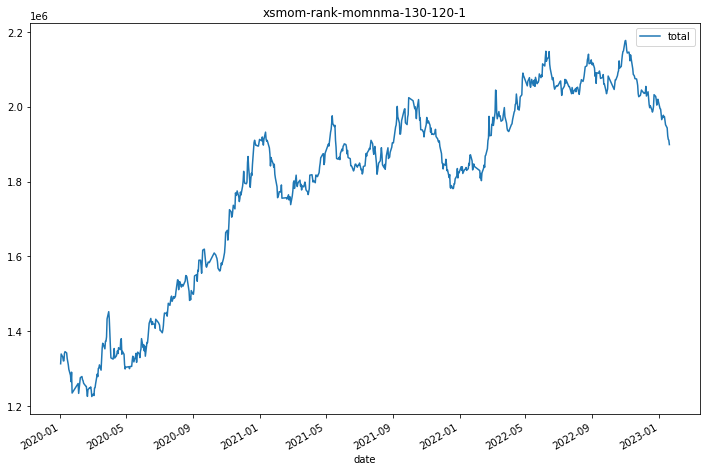

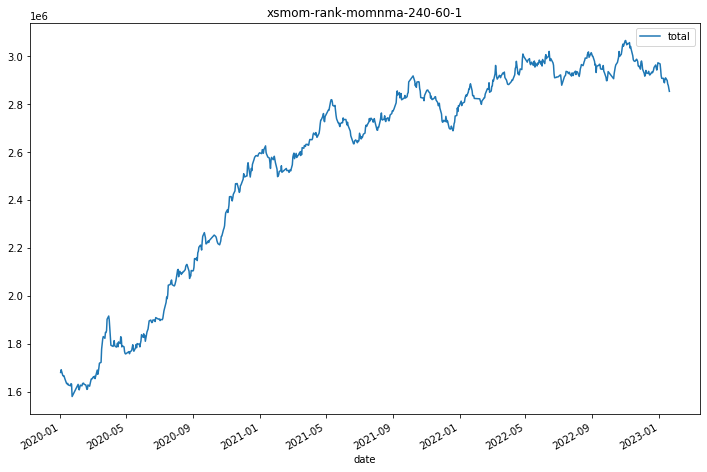

In [46]:
scen_start = pd.to_datetime('2020-01-01')
df_list = []
for scen_name, scen_stat in zip(scen_names, scen_stats):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
